## 2. Investigation

In this notebook, we want to understand the BMA results:


###  Dataset

We use the otuput from the algoritgm BMA Stellar Mass (Palmese et al. 2019)

In [2]:
import numpy as np
from astropy.table import Table, vstack
from astropy.io.fits import getdata
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

# 'font.sans-serif': ['Arial',
#   'DejaVu Sans',
#   'Liberation Sans',
#   'Bitstream Vera Sans',
#   'sans-serif'],

In [3]:
root = '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/'

In [4]:
file_bkg= root+'cosmoDC2_v1.1.4_bma_bkg_ztrue.fits'
galb = Table(getdata(file_bkg))

In [5]:
cut= galb['stellar_mass']>7e9
galb= galb[cut]

In [6]:
galb

<Table length=90119>
                  magerr [4]                  ...          ssfr         
                   float64                    ...        float64        
--------------------------------------------- ... ----------------------
 0.005691922059039469 .. 0.004706496002175418 ... 1.3272829568496228e-15
 0.013912366946744935 .. 0.008263538718571266 ...   3.97237658383258e-14
 0.005168826166513941 .. 0.006357032523973613 ... 1.0994085233058201e-09
  0.013056096911882245 .. 0.00976608994918638 ...  1.650701070146071e-11
  0.01260985110104226 .. 0.016053606916156263 ... 2.7716665642678345e-11
  0.019366585932413735 .. 0.02187156379627199 ...  6.002608045438168e-11
0.006325926497211136 .. 0.0048861205421516255 ... 2.4715655544918187e-16
  0.01513731129417907 .. 0.012699336165541307 ...  7.188492096865028e-10
  0.008996874538869994 .. 0.00591059069379471 ... 3.6308882064188863e-13
    0.010393734925377436 .. 0.008187870734886 ... 1.0160502407612451e-10
                                          ... ...                    ...
   0.09234510870696017 .. 0.03418481458684867 ... 4.2281942779722407e-10
  0.04714452567854119 .. 0.020153689205155065 ...  2.801238270446346e-11
   0.04162175477851326 .. 0.03286395188575871 ...  3.988587064498481e-11
  0.15038374283401787 .. 0.059709964389281826 ... 3.5337211749694065e-11
   0.01624953384450113 .. 0.01554211027184701 ...  7.510159098708358e-10
  0.016956733461478253 .. 0.01045118582475414 ...  7.937014137382549e-13
   0.09220372733125537 .. 0.12126723791728432 ...  7.933926714134607e-11
 0.040305008419935624 .. 0.026223798744790958 ...  9.513564600506124e-12
   0.037734005337943126 .. 0.0315748454401352 ... 1.3603019609069677e-10
    0.0939544577001844 .. 0.03401846348039052 ...  3.999465513674651e-14

In [ ]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")

from main import copacabana
from make_input_files.make_input_datasets import *

In [ ]:
cfg = '/home/s1/jesteves/git/ccopa/config_files/config_copa_dc2.yaml'
copa = copacabana(cfg)

run = 'emuBPZ-rhod-zw'
cat   = copa.load_copa_out('cluster',run=run)
gal0  = copa.load_copa_out('members',run=run)

In [ ]:
cut= (gal0['stellar_mass']>7e9)&(gal0['True'])
gal= gal0[cut]

In [ ]:
len(gal)

### Save catalog to retrieve rs_flag

We save this catalog to match on NERSC with the new columns of rs_flag

In [ ]:
myfile = 'cosmoDC2_bma_cluster_galaxies.fits'
gal.write(myfile,format='fits',overwrite=True)

myfile = 'cosmoDC2_bma_field_galaxies.fits'
galb.write(myfile,format='fits',overwrite=True)

###  Stellar Mass Validation

In this section we measure the stellar mass accuracy of BMA Stellar Mass.

In [27]:
def get_residual_variables(data,kind,cut=[None,None]):
    zcls = data['z_true']
    if kind=='mass':
        toto = (data['stellar_mass']/10**data['mass'])
        res  = np.log10(toto)
        xvar = data['stellar_mass']
    else:
        res  = (data['Mr']/data['rabs'])  
        xvar = data['Mr']
    xvar = data['stellar_mass']
    mask = np.logical_not(np.isnan(res))
    if cut[0] is not None:
        mask &= data[cut[0]] >= cut[1]
        
    return zcls[mask],res[mask], xvar[mask]

def evolution(data,col,ax=None,s=5,alpha=0.1,title=''):
    if ax is None: ax=plt.axes()
    x = data['z_true']
    y = data[col]
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)
    
def residual_evolution(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',label=True):
    if ax is None: ax=plt.axes()
    z,residual,_ = get_residual_variables(data,kind,cut=cut)
    ax.scatter(z,residual,s=s,alpha=alpha)
    if label: ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)

def residual_logmas(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',density=False,log=True,color='b'):
    if ax is None: ax=plt.axes()
    zcls,residual,xvar = get_residual_variables(data,kind,cut=cut)
    if density:
        idx = np.argsort(-1*zcls)[::1]
        im = ax.scatter(xvar[idx],residual[idx],s=s,alpha=alpha,c=zcls[idx],cmap='Paired')
        fig.colorbar(im,ax=ax)
    else:
        ax.scatter(xvar,residual,s=s,alpha=alpha,color=color)
    ax.set_xlabel(r'Log($M_{\star}^{DC2}/ M_{\odot}$)')
    ax.set_title(title)
    if log: ax.set_xscale('log')

In [28]:
mass_label = r'Log $\left(M_{\star}^{DC2} / M_{\star}^{BMA} \right)$'
mr_label   = r'$M_r^{DC2}/M_r^{BMA}$'
residual_labels = [mass_label,mr_label]

Text(0,0.5,'$M_{\\star}^{DC2}$')

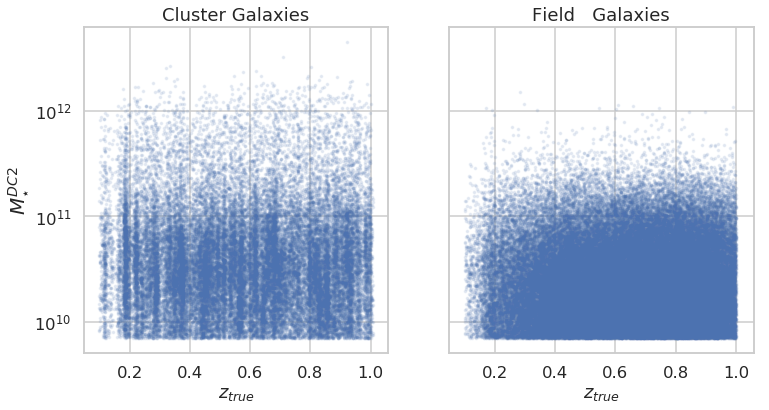

In [29]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
evolution(gal ,'stellar_mass',ax=axis[0],title='Cluster Galaxies')
evolution(galb,'stellar_mass',ax=axis[1],title='Field   Galaxies')
axis[0].set_yscale('log')
axis[0].set_ylabel(r'$M_{\star}^{DC2}$',fontsize=20)
# axis[0].set_xscale('log')
#axis[0].set_ylim(1,-1.)

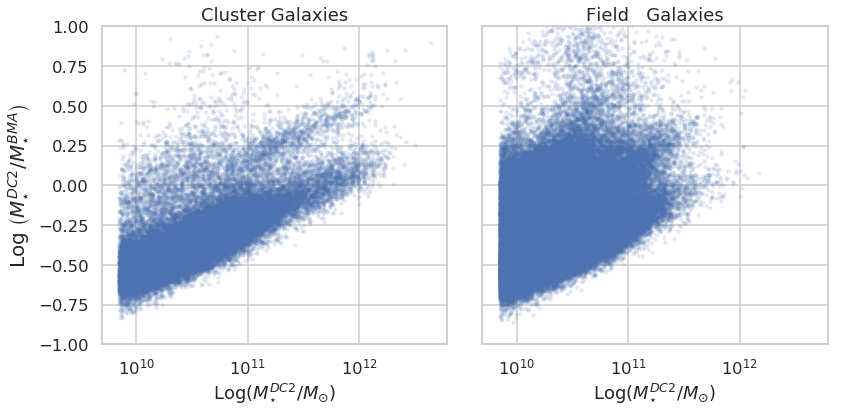

In [53]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_logmas(gal ,'mass',alpha=0.1,s=10,ax=axis[0],title='Cluster Galaxies')
residual_logmas(galb,'mass',alpha=0.1,s=10,ax=axis[1],title='Field   Galaxies')
axis[0].set_ylabel(residual_labels[0],fontsize=20)
# axis[0].set_xscale('log')
axis[0].set_ylim(-1,1.)
fig.tight_layout()

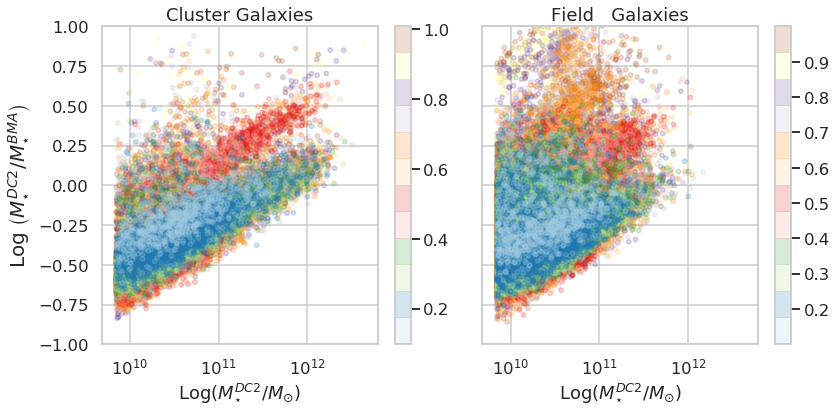

In [31]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_logmas(gal ,'mass',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies',density=True)
residual_logmas(galb,'mass',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies',density=True)
axis[0].set_ylabel(residual_labels[0],fontsize=20)
# axis[0].set_xscale('log')
axis[0].set_ylim(-1,1.)
fig.tight_layout()
plt.savefig('../graphs/mass_residual_logmass.png')

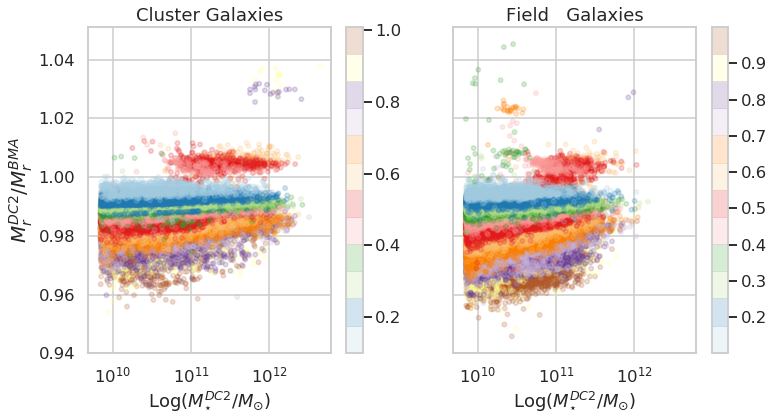

In [32]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_logmas(gal ,'Mr',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies',density=True,log=True)
residual_logmas(galb,'Mr',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies',density=True,log=True)
axis[0].set_ylabel(residual_labels[1],fontsize=20)
# axis[0].set_xscale('log')
# axis[0].set_ylim(1,-1.)
plt.savefig('../graphs/Mr_residual_logmass.png')

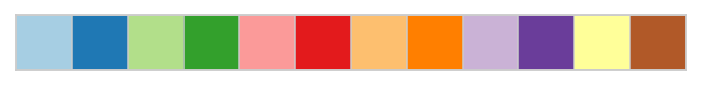

In [33]:
sns.palplot(sns.color_palette("Paired"))

In [34]:
colorGradient = sns.color_palette("Paired")[:]

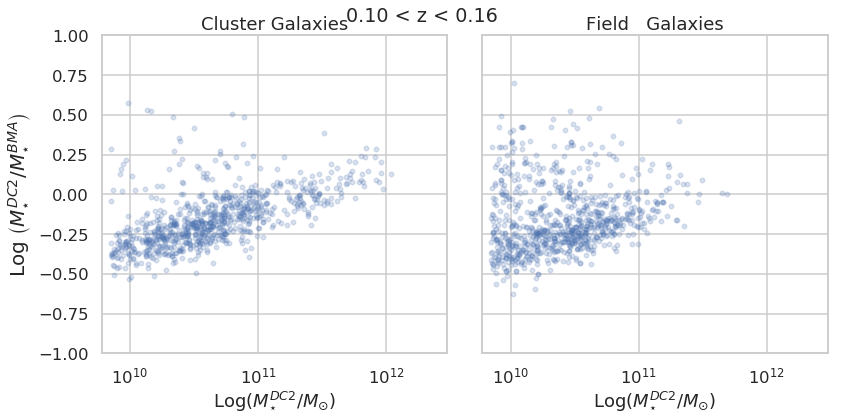

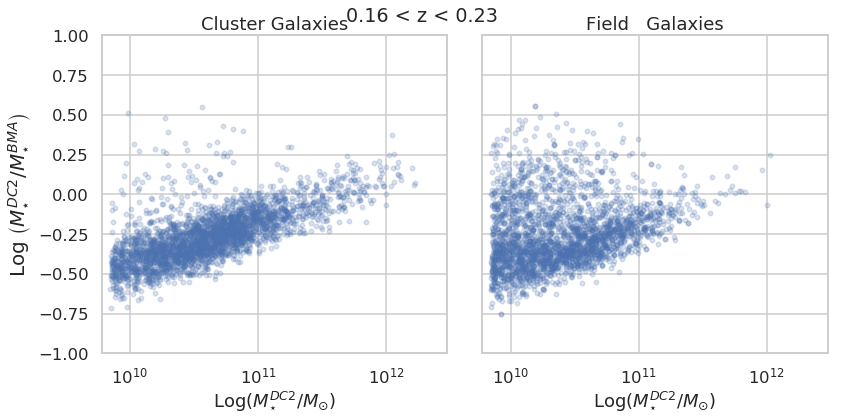

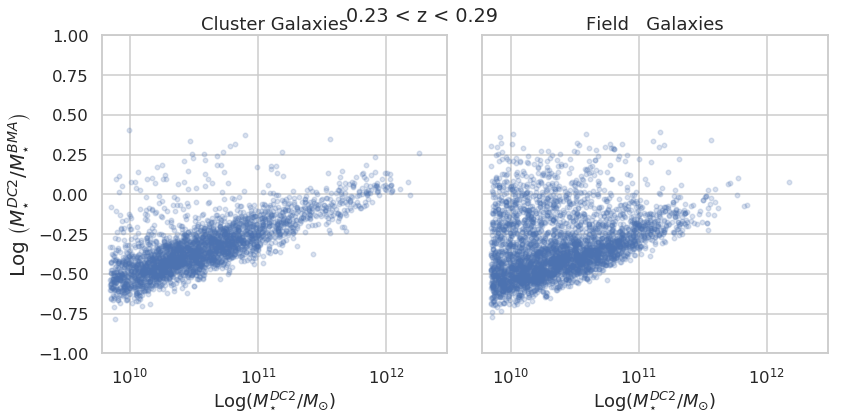

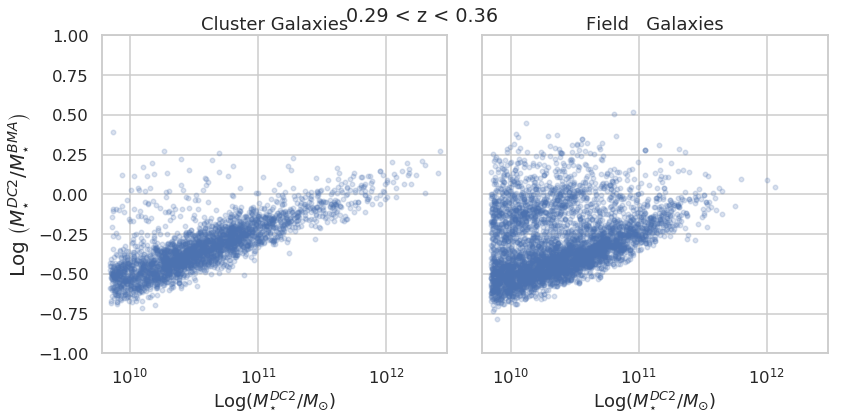

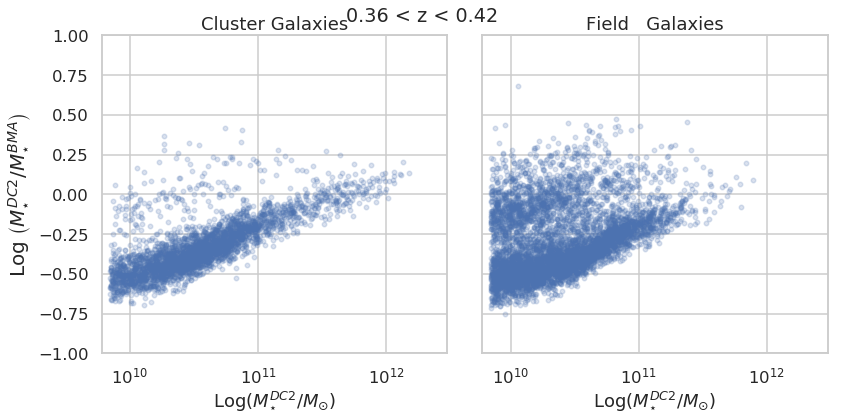

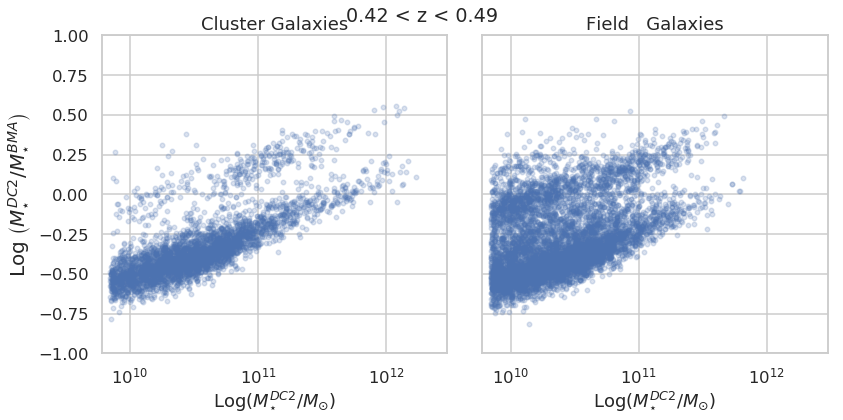

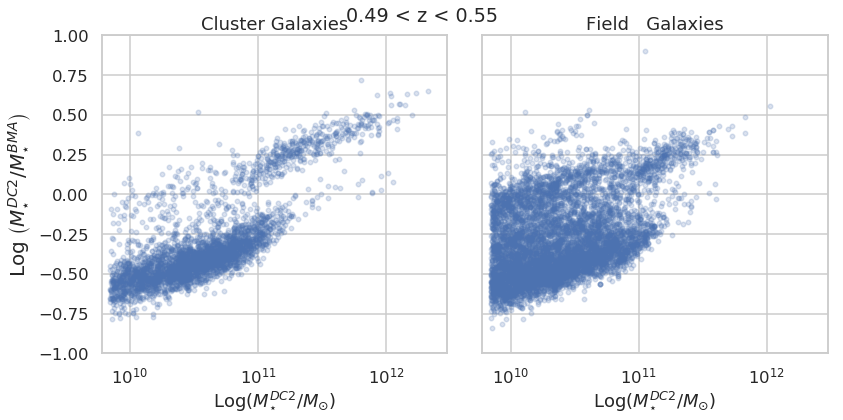

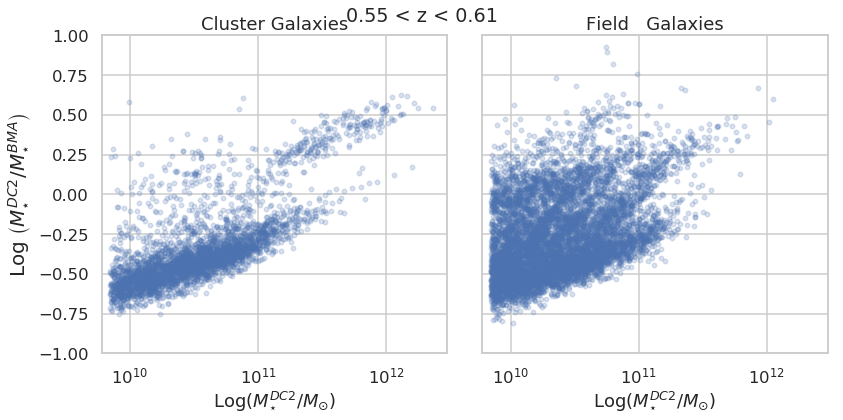

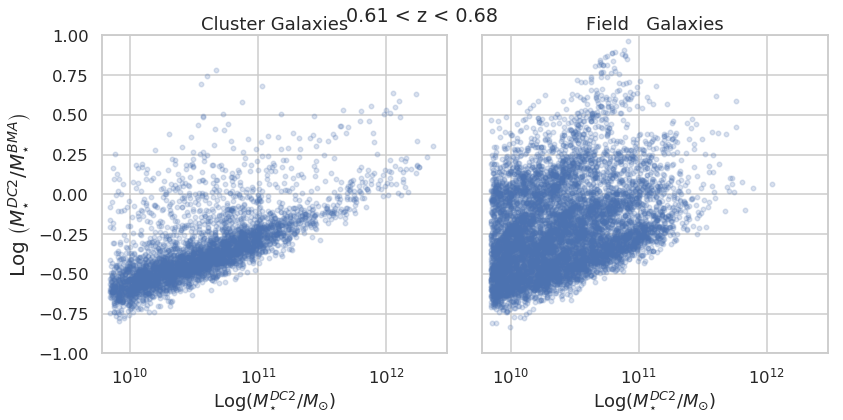

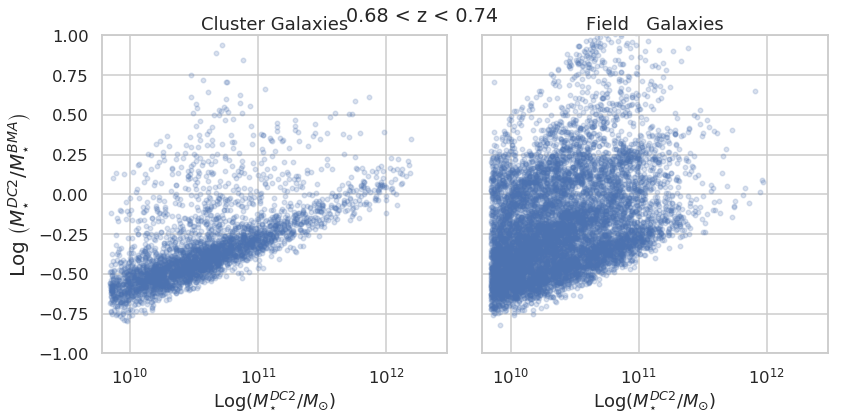

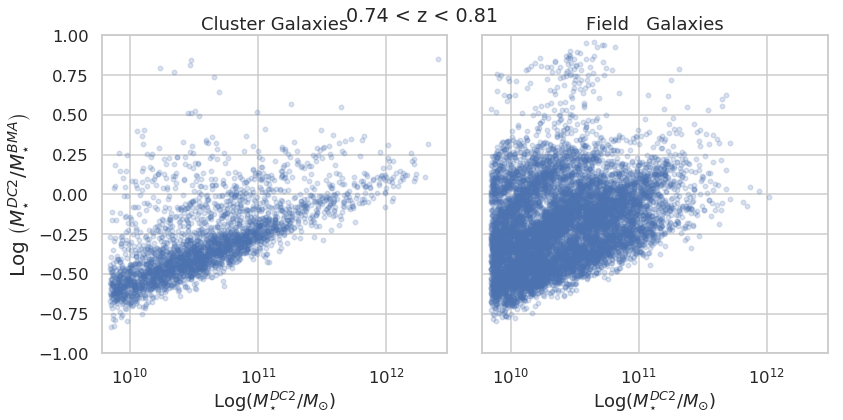

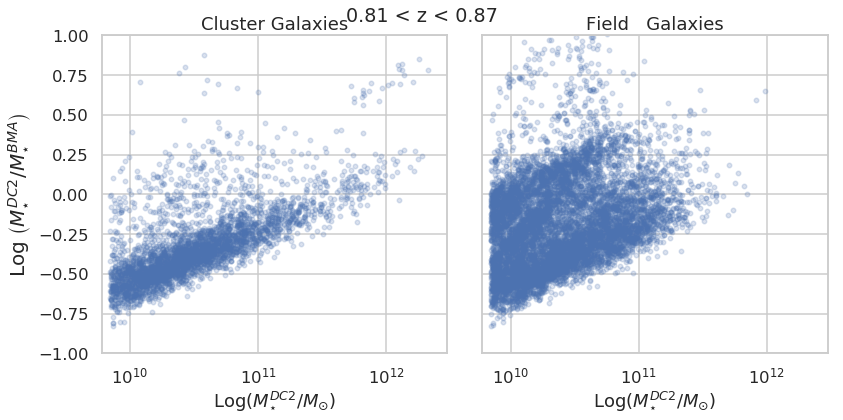

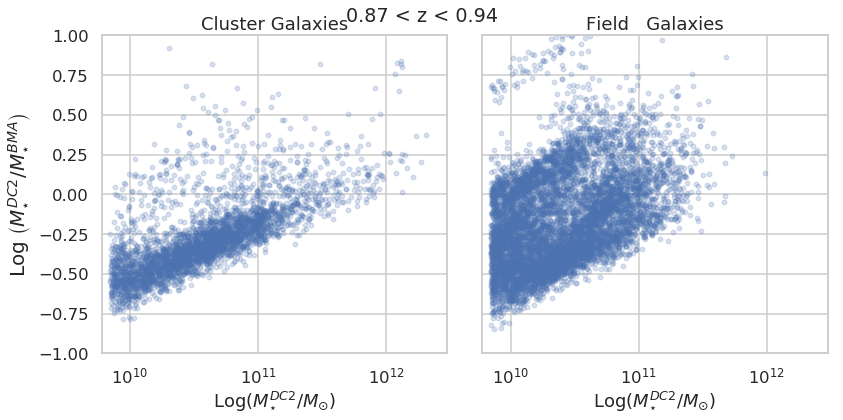

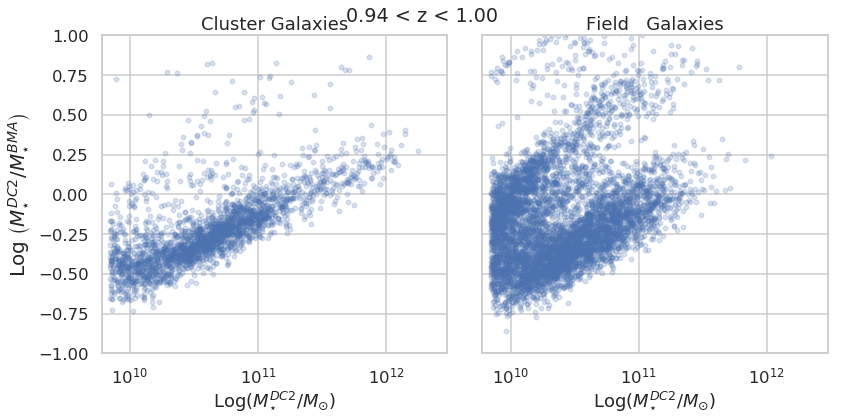

In [35]:
zbins = np.linspace(0.1,1.,15)

for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    maska = (gal['z_true']>=zl)&(gal['z_true']<=zh)
    maskb = (galb['z_true']>=zl)&(galb['z_true']<=zh)

    fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
    residual_logmas(gal[maska] ,'mass',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies')
    residual_logmas(galb[maskb],'mass',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies')
    axis[0].set_ylabel(residual_labels[0],fontsize=20)
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))
    axis[0].set_ylim(-1.,1.)
    axis[0].set_xlim(6e9,3e12)
    fig.tight_layout()
    plt.savefig('../graphs/gif/mass_residual_{:02d}.png'.format(i))
# axis[0].set_xscale('log')


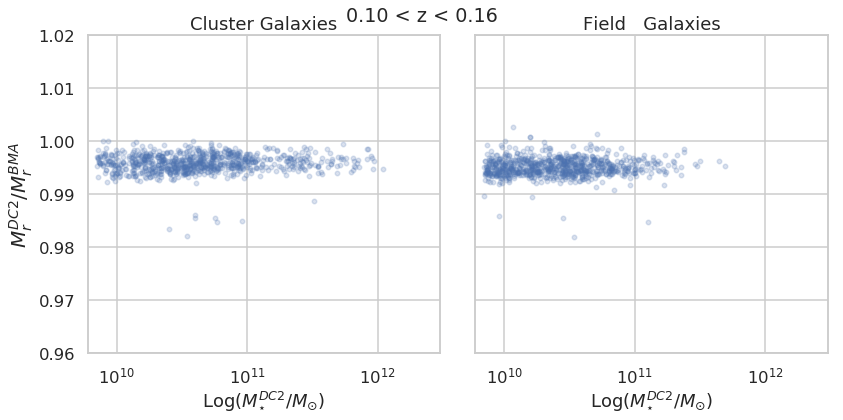

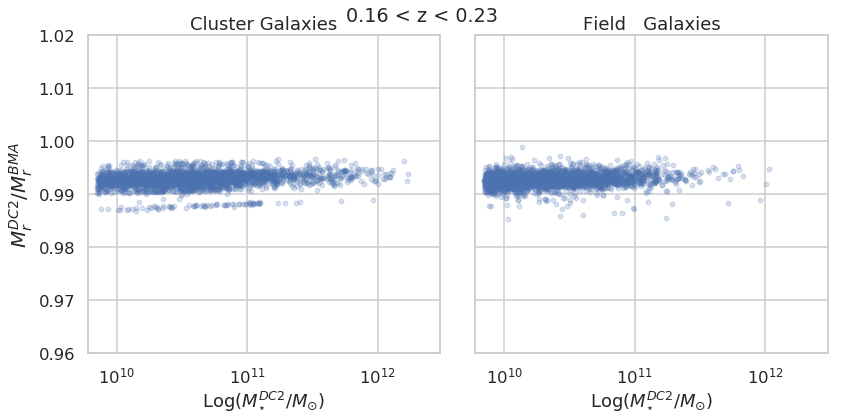

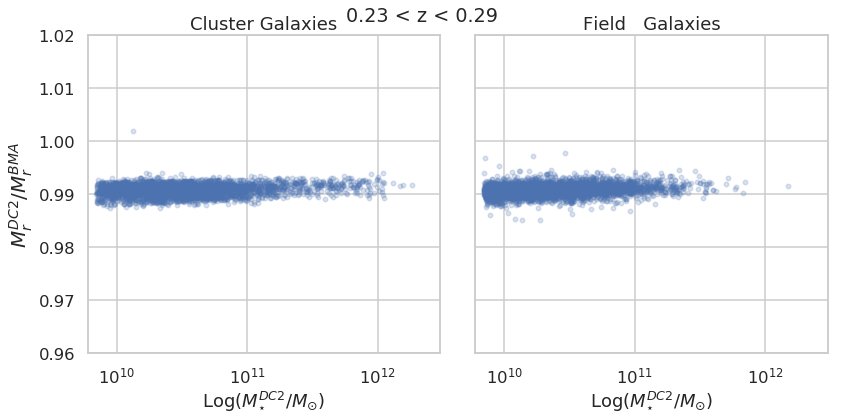

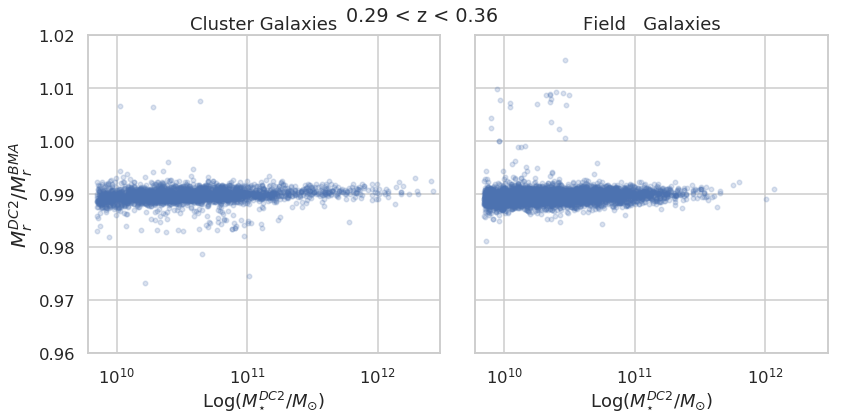

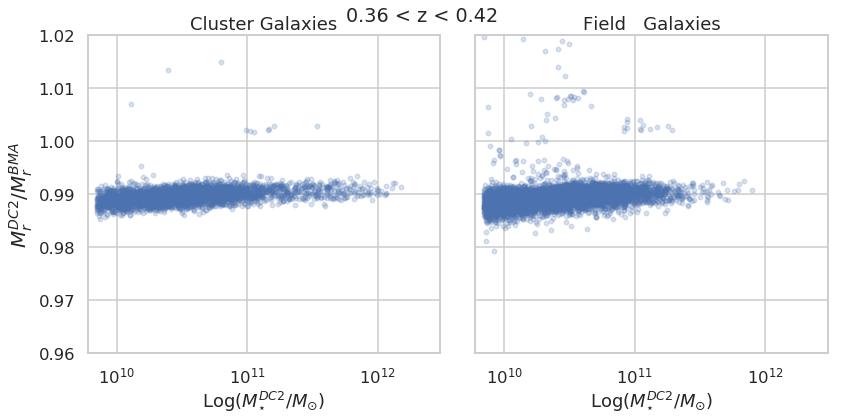

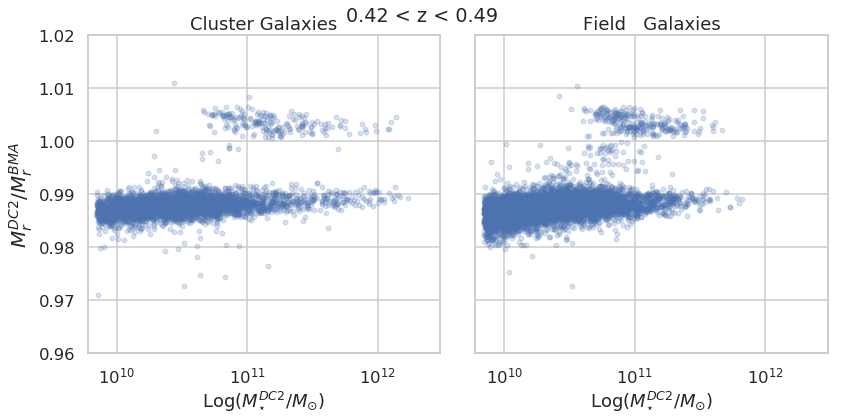

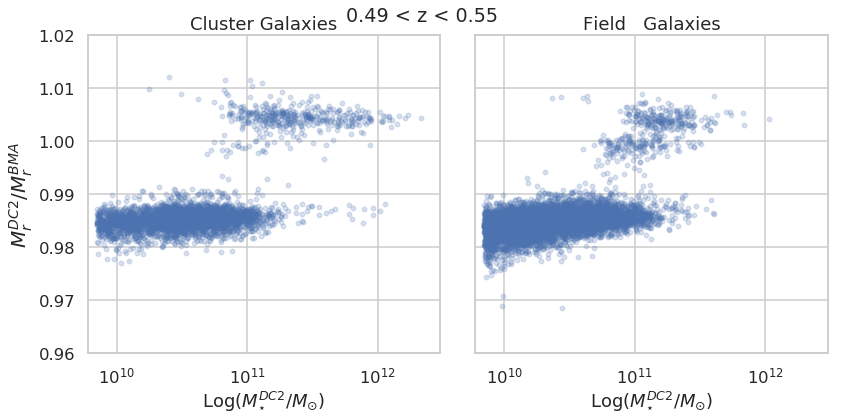

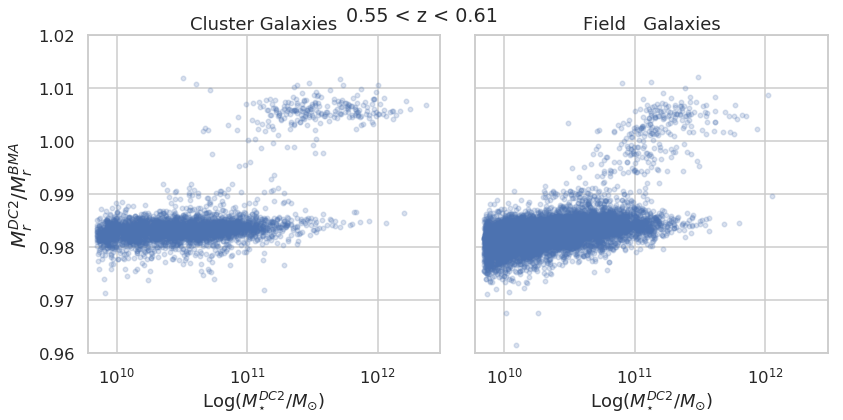

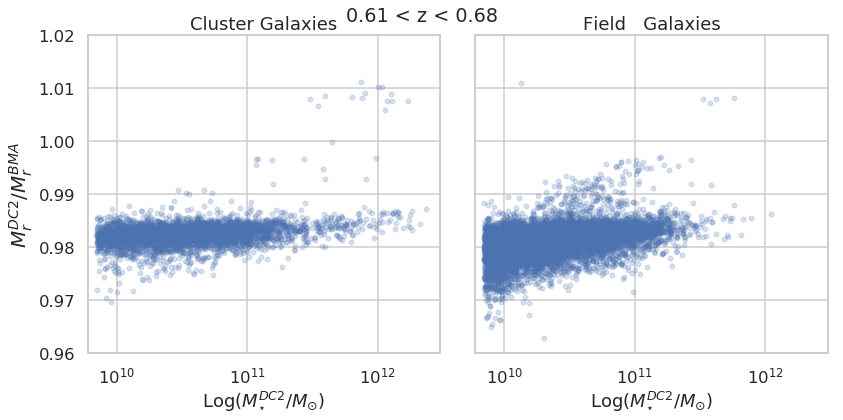

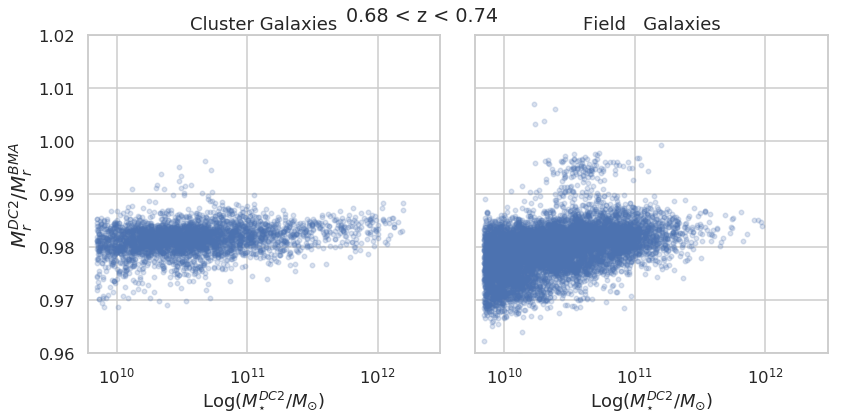

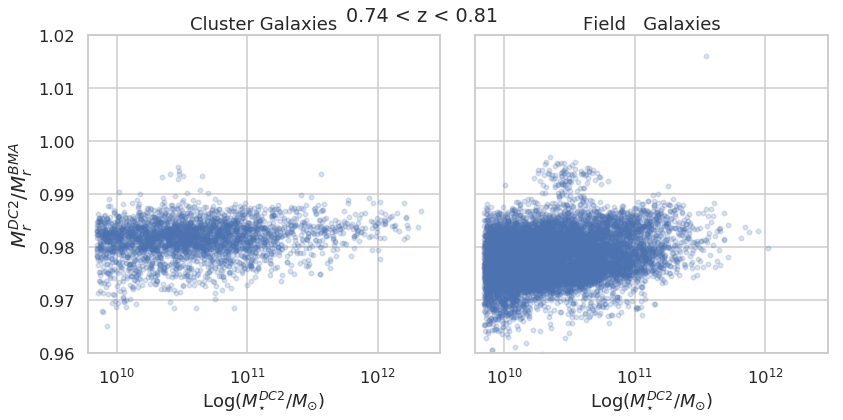

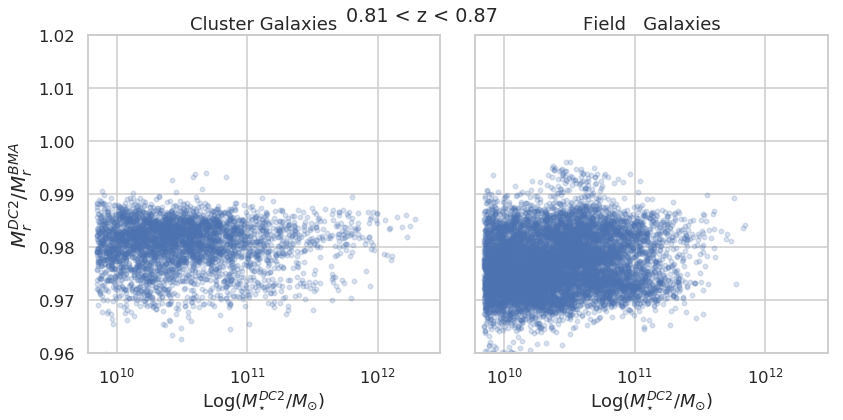

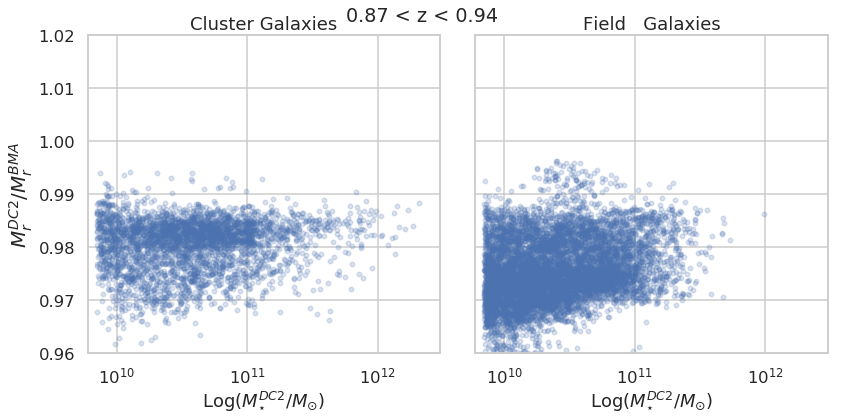

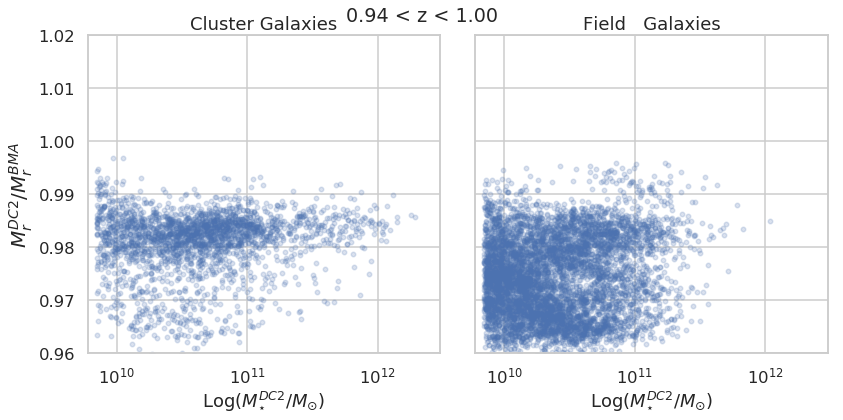

In [36]:
zbins = np.linspace(0.1,1.,15)

for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    maska = (gal['z_true']>=zl)&(gal['z_true']<=zh)
    maskb = (galb['z_true']>=zl)&(galb['z_true']<=zh)

    fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
    residual_logmas(gal[maska] ,'Mr',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies')
    residual_logmas(galb[maskb],'Mr',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies')
    axis[0].set_ylabel(residual_labels[1],fontsize=20)
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))
    axis[0].set_ylim(0.96,1.02)
    axis[0].set_xlim(6e9,3e12)
    fig.tight_layout()
    plt.savefig('../graphs/gif/Mr_residual_{:02d}.png'.format(i))
# axis[0].set_xscale('log')


(1, -1.0)

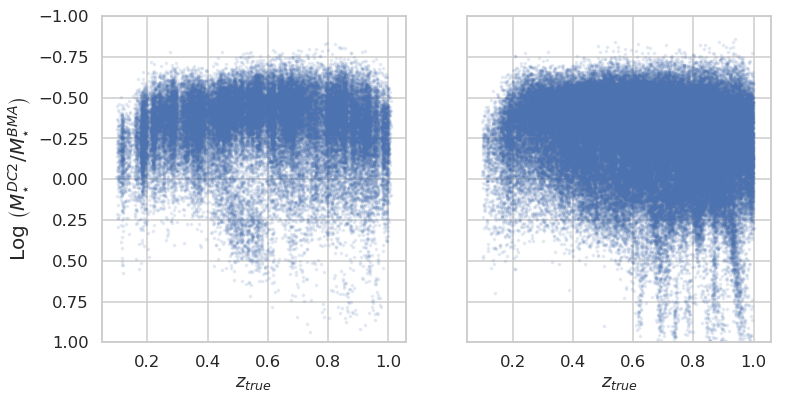

In [37]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal ,'mass',ax=axis[0])
residual_evolution(galb,'mass',ax=axis[1])
axis[0].set_ylabel(residual_labels[0],fontsize=20)
axis[0].set_ylim(1,-1.)

Text(0,0.5,'Log $\\left(M_{\\star}^{DC2} / M_{\\star}^{BMA} \\right)$')

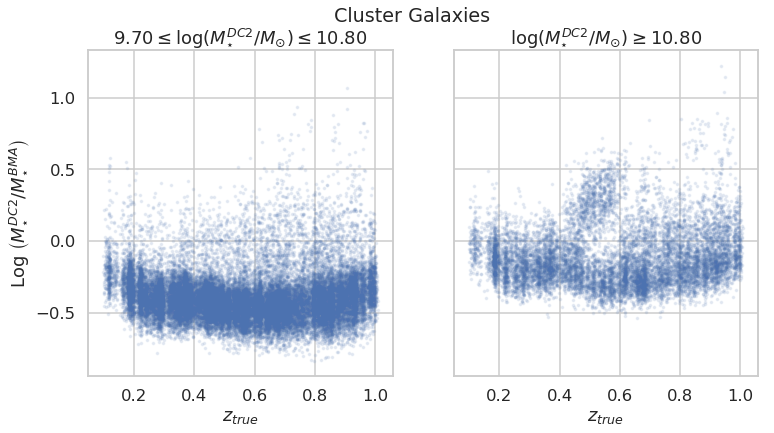

In [38]:
ml,mh = 10**9.7, 10**10.8
mask1 = (gal['stellar_mass']>=ml)&(gal['stellar_mass']<=mh)
mask2 = (gal['stellar_mass']>=mh)


fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask1],'mass',ax=axis[0],title=r'$ %.2f \leq \log (M_{\star}^{DC2}/M_{\odot}) \leq %.2f$ '%(np.log10(ml),np.log10(mh)))
residual_evolution(gal[mask2],'mass',ax=axis[1],title=r'$ \log (M_{\star}^{DC2}/M_{\odot}) \geq %.2f$'%np.log10(mh))
fig.suptitle('Cluster Galaxies')
axis[0].set_ylabel(residual_labels[0])
# axis[0].set_ylim(1,-1.)

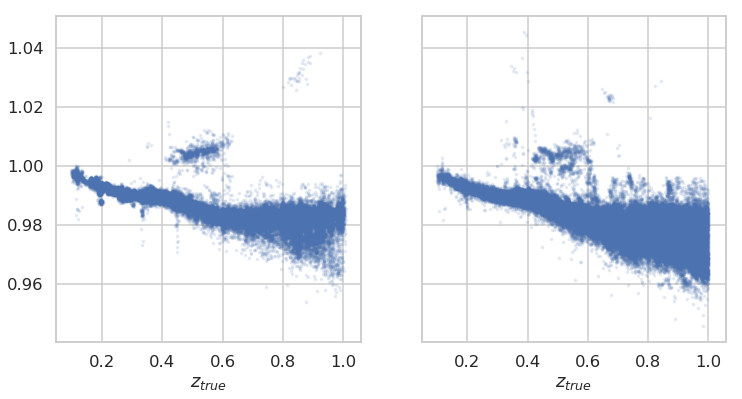

In [39]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal ,'Mr',ax=axis[0])
residual_evolution(galb,'Mr',ax=axis[1])
# axis[0].set_ylim(1,-1.)

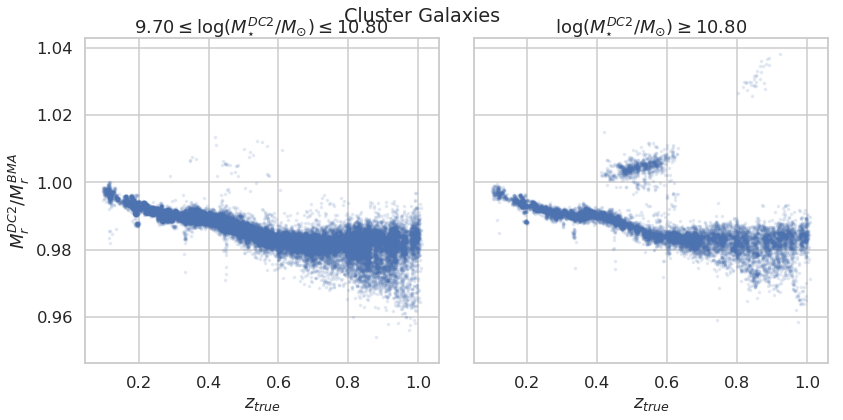

In [40]:
ml,mh = 10**9.7, 10**10.8
mask1 = (gal['stellar_mass']>=ml)&(gal['stellar_mass']<=mh)
mask2 = (gal['stellar_mass']>=mh)


fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask1],'Mr',ax=axis[0],title=r'$ %.2f \leq \log (M_{\star}^{DC2}/M_{\odot}) \leq %.2f$ '%(np.log10(ml),np.log10(mh)))
residual_evolution(gal[mask2],'Mr',ax=axis[1],title=r'$ \log (M_{\star}^{DC2}/M_{\odot}) \geq %.2f$'%np.log10(mh))
fig.suptitle('Cluster Galaxies')
axis[0].set_ylabel(residual_labels[1])
fig.tight_layout()
plt.savefig('../graphs/residual_Mr_evolution.png')
# axis[0].set_ylim(1,-1.)

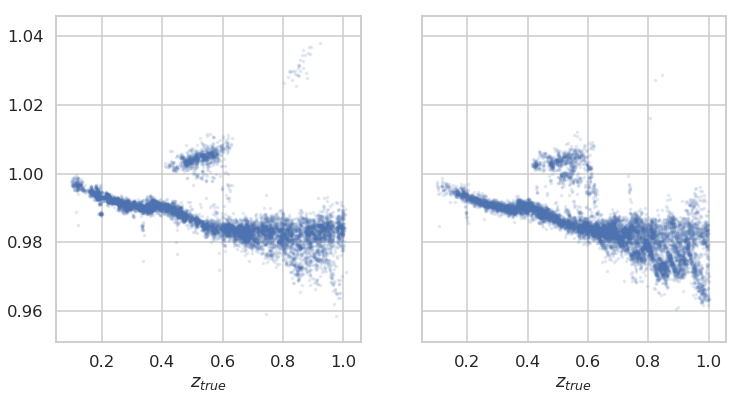

In [41]:
ml,mh = 10**10.9, 10**14
maska = (gal['stellar_mass']>=ml)&(gal['stellar_mass']<=mh)
maskb = (galb['stellar_mass']>=ml)&(galb['stellar_mass']<=mh)

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[maska],'Mr',ax=axis[0])
residual_evolution(galb[maskb],'Mr',ax=axis[1])
# axis[0].set_ylim(1,-1.)

###  Select the second population

In this lines we will classify the distribution in two populations: A and B

In [42]:
def get_labels(data):
    z,residual,mass = get_residual_variables(data,'Mr')
    mask = (residual > 1.)&(z>0.4)&(z<0.7)
    return mask

In [43]:
pop = get_labels(gal)
npop= np.logical_not(pop)

In [44]:
popb = get_labels(galb)
npopb= np.logical_not(popb)

In [45]:
mh = 10**(10.8)
mask2 = (gal['stellar_mass']>=mh)
mask2b= (galb['stellar_mass']>=mh)

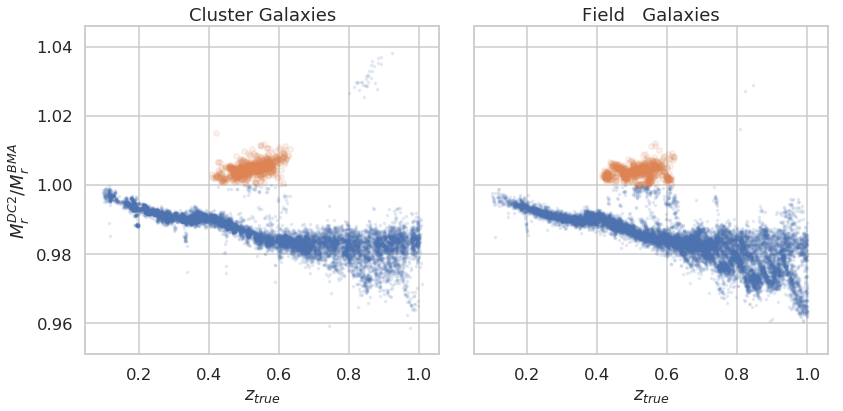

In [46]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask2&(npop)],'Mr',ax=axis[0])
residual_evolution(gal[mask2&(pop )],'Mr',s=30,ax=axis[0],title='Cluster Galaxies')

residual_evolution(galb[mask2b&(npopb)],'Mr',ax=axis[1])
residual_evolution(galb[mask2b&(popb)],'Mr',s=30,ax=axis[1],title='Field   Galaxies')
axis[0].set_ylabel(residual_labels[1])
fig.tight_layout()

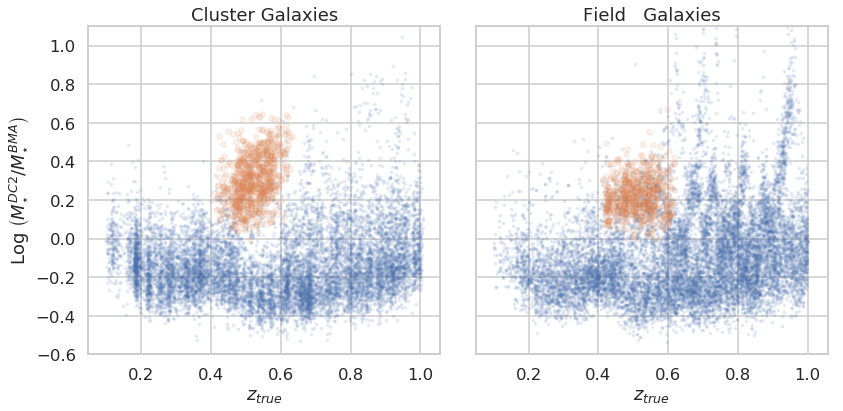

In [52]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask2&(npop)],'mass',ax=axis[0])
residual_evolution(gal[mask2&(pop )],'mass',s=30,ax=axis[0],title='Cluster Galaxies')

residual_evolution(galb[mask2b&(npopb)],'mass',ax=axis[1])
residual_evolution(galb[mask2b&(popb)],'mass',s=30,ax=axis[1],title='Field   Galaxies')
axis[0].set_ylim(-0.6,1.1)
axis[0].set_ylabel(residual_labels[0])
fig.tight_layout()

In [48]:
### plot color

### Looking for Correlations

On color, radial, 

In [57]:
def calculcate_color_column(data):
    labels = ['g-r','r-i','i-z']
    for i in range(3):
        data[labels[i]] = data['mag'][:,i]-data['mag'][:,i+1]
    return data

In [58]:
gal = calculcate_color_column(gal)
galb= calculcate_color_column(galb)

In [59]:
## DES Y3 redMaPPer
redSequence_file = '/home/s1/jesteves/backup/Memb-assign/aux-table/redSequence_Fit_redmapper_z_binned_Pmem_cut.txt'
rs = np.genfromtxt(redSequence_file)

# z,gr_mean,gr_0,gr_slope, ri_mean, ri_0, ri_slope, iz_mean, ...

#### Color Distribution

In [65]:
def color_evolution(data,lcol,s=10,alpha=0.1,ax=None,title=''):
    if ax is None: ax = plt.axes()
    color = data[lcol]
    zcls  = data['z_true'][:]
    ax.scatter(zcls,color,s=s,alpha=alpha,label='_')
    ax.set_title(title)
    ax.set_xlabel(r'$z_{true}$')

def color_mag(data,lcol,ix=1,s=30,alpha=0.3,ax=None,title='',zlims=[0.,1]):
    zl,zh = zlims
    mag   = data['mag'][:,ix]
    color = data[lcol]
    zcls  = data['z_true'][:]
    mask  = (zcls<=zh)&(zcls>=zl)
    ax.scatter(mag[mask],color[mask],s=s,alpha=alpha,label='_')
    ax.set_title(title)


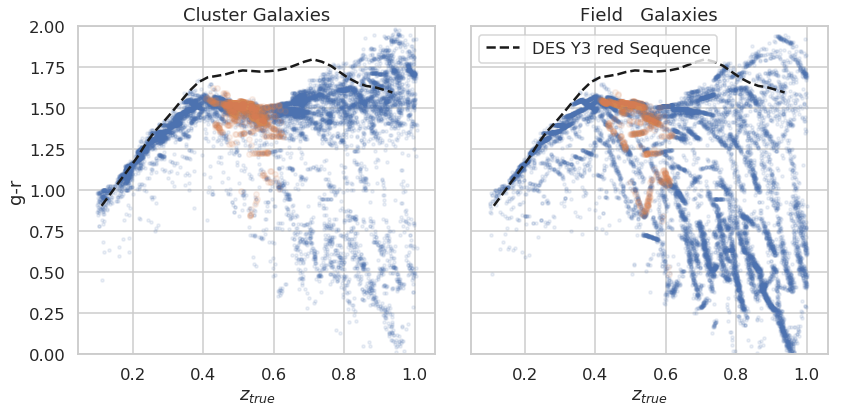

In [66]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask2&(npop)],'g-r',ax=axis[0])
color_evolution(gal[mask2&(pop )],'g-r',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,1],'k--')

color_evolution(galb[mask2b&(npopb)],'g-r',ax=axis[1])
color_evolution(galb[mask2b&(popb)],'g-r',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,1],'k--',label='DES Y3 red sequence')

axis[0].set_ylabel('g-r')
axis[0].set_ylim(0.,2.)
axis[1].legend()
fig.tight_layout()

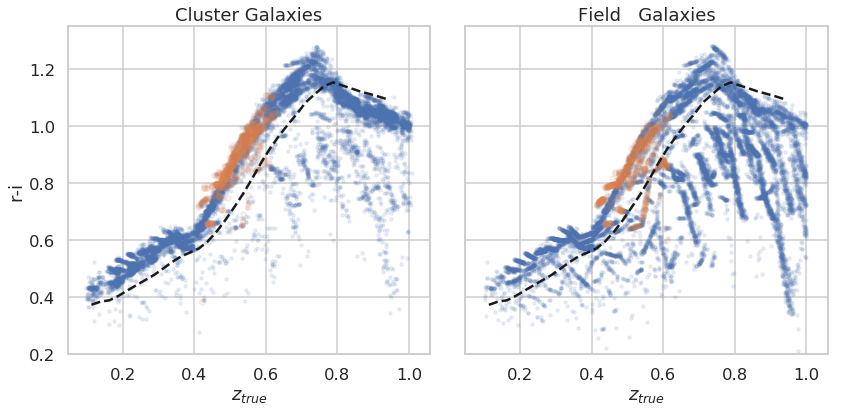

In [69]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask2&(npop)],'r-i',ax=axis[0])
color_evolution(gal[mask2&(pop )],'r-i',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,4],'k--')


color_evolution(galb[mask2b&(npopb)],'r-i',ax=axis[1])
color_evolution(galb[mask2b&(popb)],'r-i',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,4],'k--',label='DES Y3 red sequence')
axis[0].set_ylabel('r-i')
axis[0].set_ylim(0.2,1.35)
fig.tight_layout()

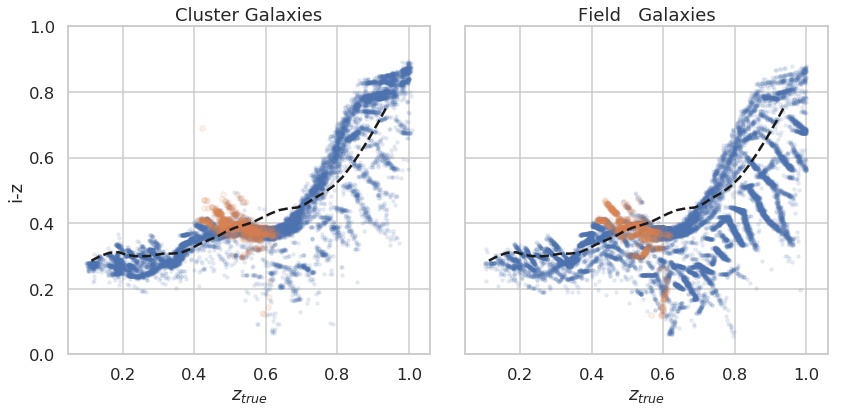

In [163]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask2&(npop)],'i-z',ax=axis[0])
color_evolution(gal[mask2&(pop )],'i-z',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,7],'k--')

color_evolution(galb[mask2b&(npopb)],'i-z',ax=axis[1])
color_evolution(galb[mask2b&(popb)],'i-z',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,7],'k--')

axis[1].set_ylim(0.,1.)
axis[0].set_ylabel('i-z')
fig.tight_layout()

In [75]:
zbins = np.linspace(0.4,0.63,11)

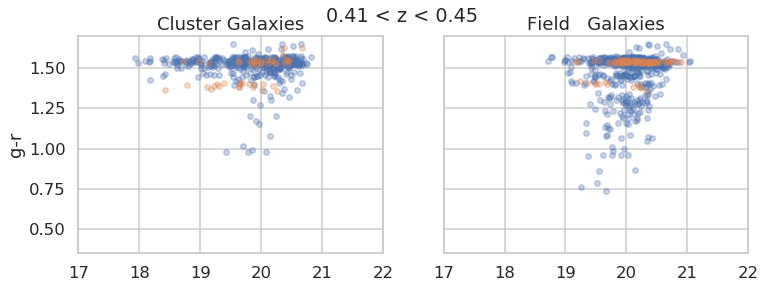

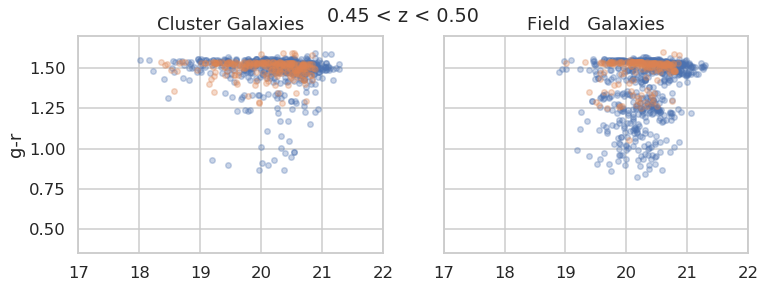

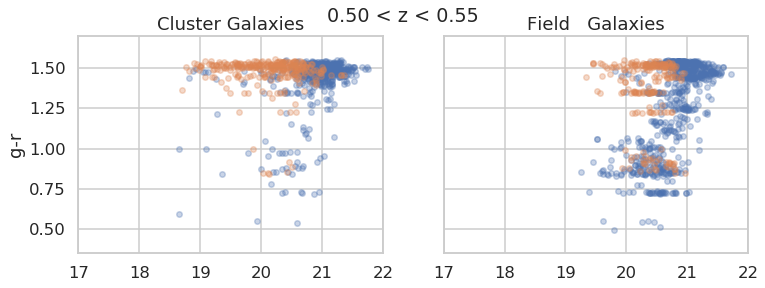

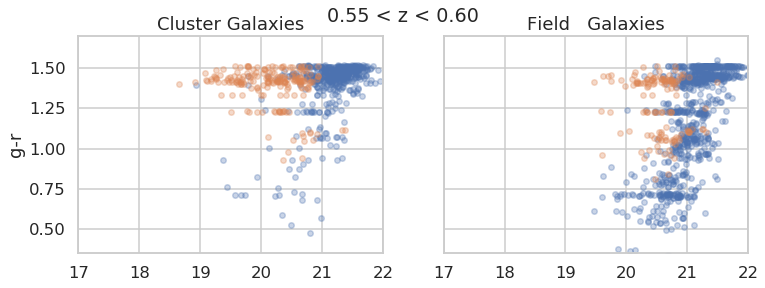

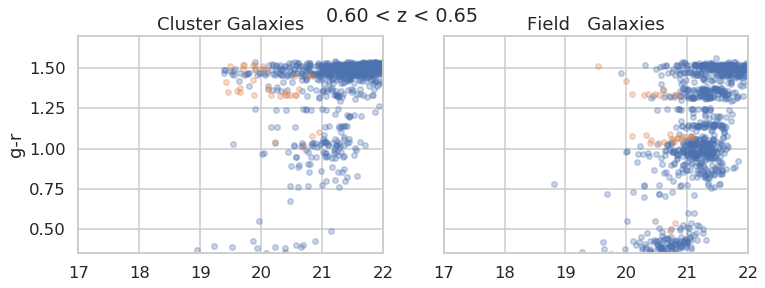

In [71]:
for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex='all',sharey='all')

    color_mag(gal[mask2&(npop)],'g-r',ax=axis[0],zlims=[zl,zh])
    color_mag(gal[mask2&(pop )],'g-r',s=30,ax=axis[0],title='Cluster Galaxies',zlims=[zl,zh])

    color_mag(galb[mask2b&(npopb)],'g-r',ix=1,ax=axis[1],zlims=[zl,zh])
    color_mag(galb[mask2b&(popb)],'g-r',ix=1,s=30,ax=axis[1],title='Field   Galaxies',zlims=[zl,zh])
    axis[0].set_ylabel('g-r')
    axis[0].set_xlim(17,22)
    axis[0].set_ylim(0.35,1.7)
    
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))

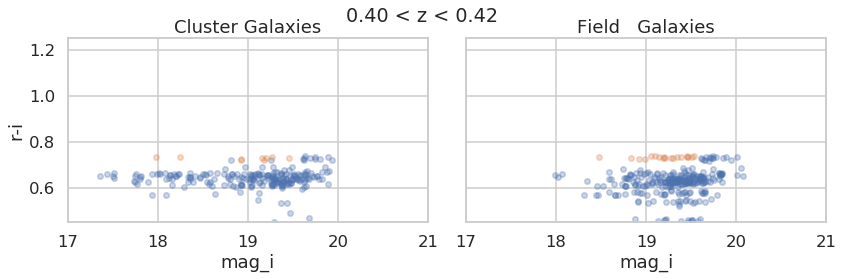

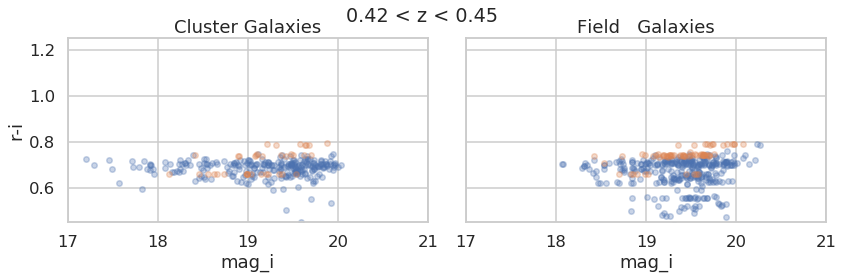

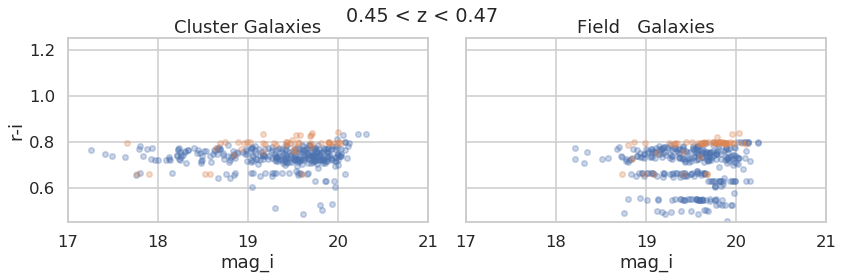

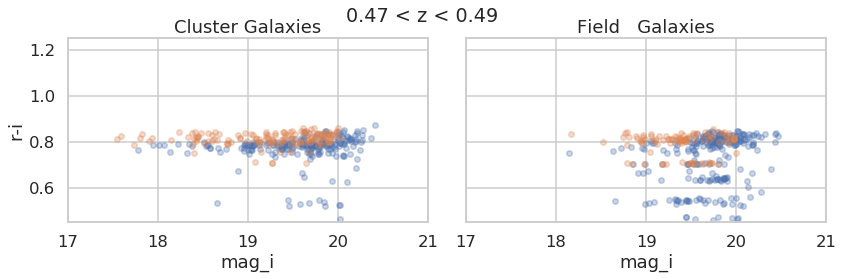

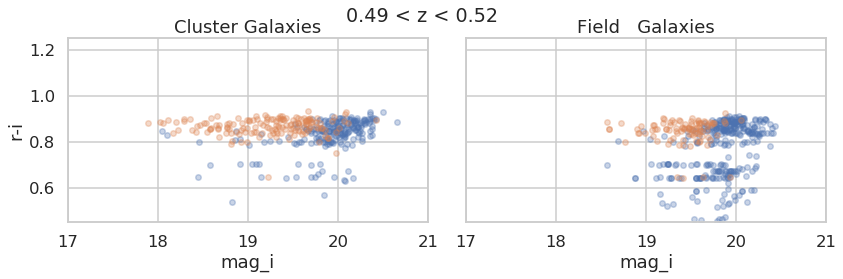

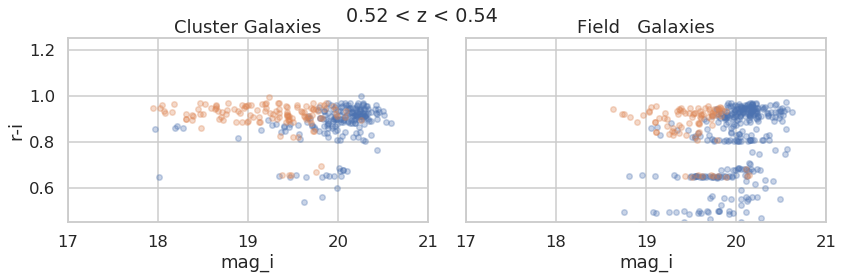

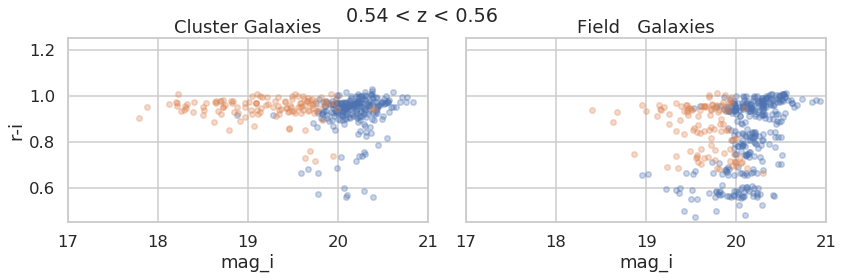

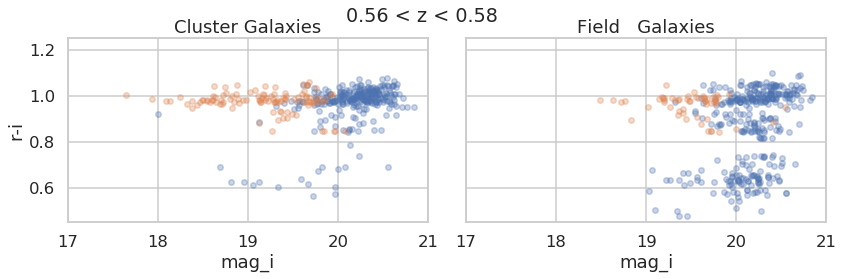

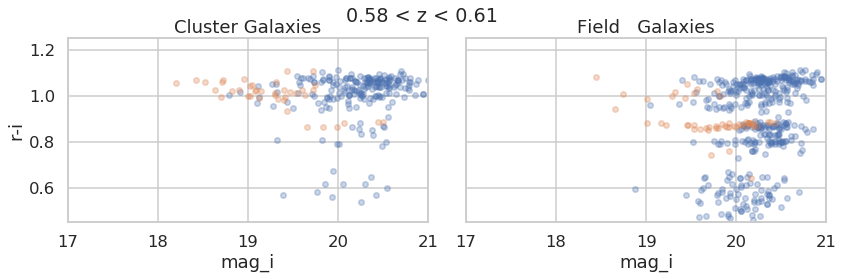

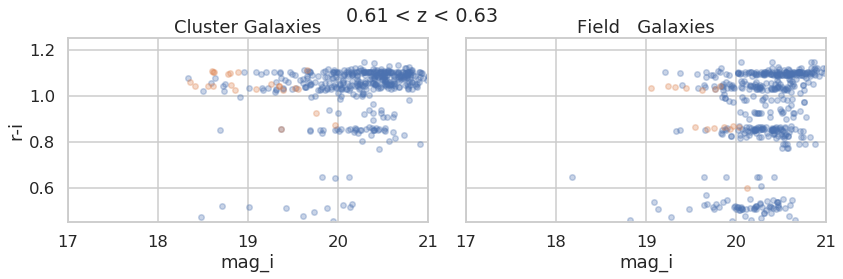

In [77]:
for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex='all',sharey='all')

    color_mag(gal[mask2&(npop)],'r-i',ix=2,ax=axis[0],zlims=[zl,zh])
    color_mag(gal[mask2&(pop )],'r-i',ix=2,s=30,ax=axis[0],title='Cluster Galaxies',zlims=[zl,zh])

    color_mag(galb[mask2b&(npopb)],'r-i',ix=2,ax=axis[1],zlims=[zl,zh])
    color_mag(galb[mask2b&(popb)],'r-i',ix=2,s=30,ax=axis[1],title='Field   Galaxies',zlims=[zl,zh])
    axis[0].set_ylabel('r-i')
    axis[0].set_xlabel('mag_i')
    axis[1].set_xlabel('mag_i')
    axis[0].set_xlim(17,21)
    axis[0].set_ylim(0.45,1.25)
    
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))
    fig.tight_layout()
    plt.savefig('../graphs/gif/color_mag_ri_{:02d}.png'.format(i))

#### Spatial Distribution

In [78]:
radii = gal['R']*0.7
radiib= galb['R']*0.7

Text(0.5,0,'R [Mpc]')

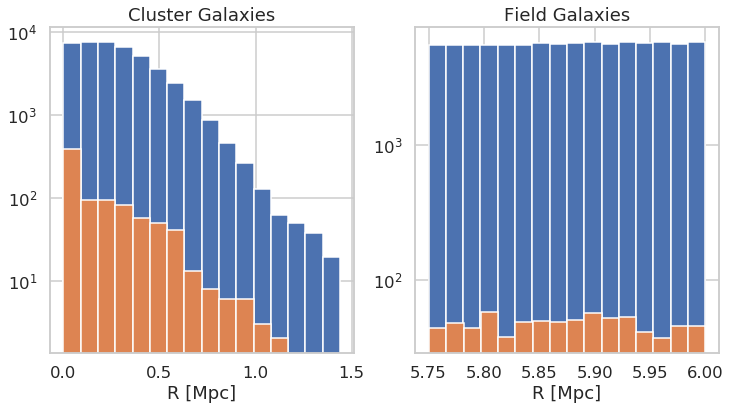

In [97]:
fig, axis = plt.subplots(1, 2, figsize=(12,6))

a = axis[0].hist(radii[npop],bins=16,density=False)
axis[0].hist(radii[pop],bins=a[1],density=False)
axis[0].set_yscale('log')
axis[0].set_title('Cluster Galaxies')
axis[0].set_xlabel('R [Mpc]')

axis[1].hist(radiib[npopb],bins=16,density=False)
axis[1].hist(radiib[popb] ,bins=16,density=False)
axis[1].set_yscale('log')
axis[1].set_title('Field Galaxies')
axis[1].set_xlabel('R [Mpc]')

In [81]:
1.*np.count_nonzero(radii[pop]<0.1)/np.count_nonzero(pop)

0.4710059171597633

In [90]:
ra, dec = gal['RA'],gal['DEC']
rab,decb= galb['RA'],galb['DEC']

Text(0,0.5,'DEC')

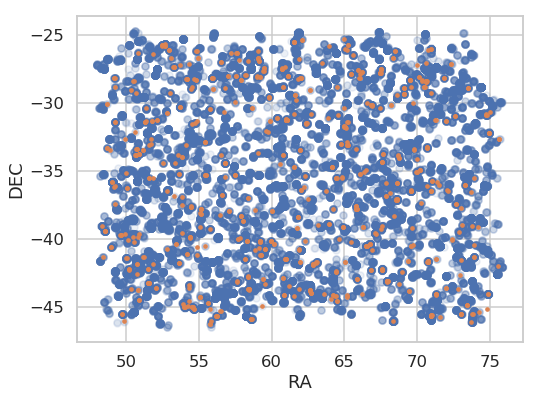

In [96]:
plt.figure(figsize=(8,6))
plt.scatter(ra[npop],dec[npop],s=50,alpha=0.1)
plt.scatter(ra[pop],dec[pop],s=10)

plt.xlabel('RA')
plt.ylabel('DEC')

### Looking for Correlations with Halos

In [99]:
def compute_nbad(keys):
    res = np.array([idx.size for idx in keys])
    return res

def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [140]:
zcls = cat['redshift']
w = (zcls>0.45)&(zcls<0.6)

In [146]:
cids  = cat['CID']
keys = list(chunks(gal['CID'][mask2&pop],cids))
keys2= list(chunks(gal['CID'][mask2],cids))

In [159]:
nbad = compute_nbad(keys)
ngals= compute_nbad(keys2)
fraction = 1.*nbad/ngals

In [148]:
ntrue = cat['Ngals_true']
m200  = cat['M200_true']

Text(0.5,0,'$f_{pop}$ per halo')

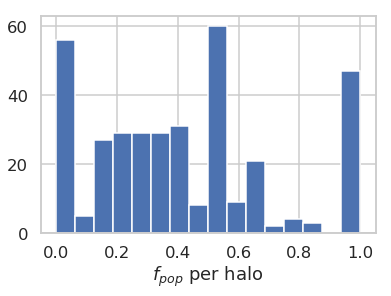

In [155]:
plt.hist(1.*nbad[w]/ngals[w],bins=16)
plt.xlabel(r'$f_{pop}$ per halo')
# plt.yscale('log')

Text(0,0.5,'$N_{pop}$')

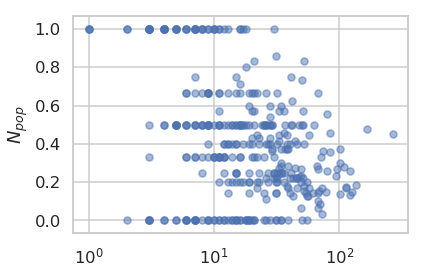

In [162]:
plt.scatter(ntrue[w],fraction[w],alpha=0.5,s=50)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0.5,)
plt.ylabel(r'$N_{pop}$')
# plt.xlabel('halo_mass')

In [182]:
ra,dec = cat['RA'],cat['DEC']

In [179]:
mask = (nbad==0)&(np.abs(cat['redshift']-0.50)<=0.10)

In [180]:
def plot_sky(ra,dec):
    plt.scatter(ra,dec)


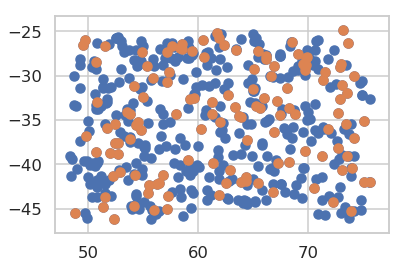

In [183]:
plot_sky(ra[w],dec[w])
plot_sky(ra[mask],dec[mask])

In [ ]:
def makeBins(variable,xedges):
    nsize=len(xedges)-1
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable < xedges[i + 1]))[0] for i in range(nsize)]
    return indices, xbins


In [413]:
def mass_scatter_residual(x1,x2,x3,zlabel='$z_{cls}$'):
    cut = remove_nan(x2)
    x = np.log10(x2[cut]/x1[cut])
    
    idx = np.flip(np.argsort(x3))
    plt.scatter(np.log10(x1)[idx],x[idx],c=x3[idx],cmap='RdBu',s=5,alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label(zlabel)

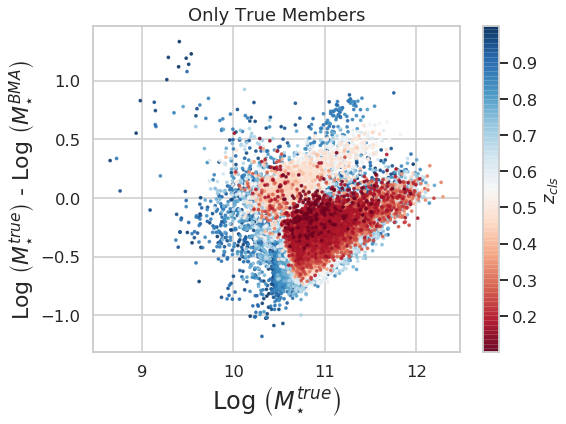

In [414]:
plt.figure(figsize=(8,6))
mass_scatter_residual(mass[mask],mass_t[mask],zcls[mask])
plt.ylabel(r'Log $\left(M_{\star}^{true} \right)$ - Log $\left( M_{\star}^{BMA} \right)$',fontsize=22)
plt.xlabel(r'Log $\left(M_{\star}^{true} \right)$',fontsize=24)

# plt.xlim(9.5,12.5)
# plt.ylim(-1.5,1.5)
plt.title('Only True Members')
plt.tight_layout()
plt.savefig('stellar_mass_residual_mtrue.png')

In [20]:
magi = gal['mag'][:,3]
amag = gal['rabs']
pmem = gal['Pmem']

In [40]:
def get_percentile_curve(x,y,q=95,nbins=12):
    xedges = np.linspace(0.98*np.min(x),1.02*np.max(x),nbins)
    keys, xmean = makeBins(x,xedges)
    ypercentile = [np.percentile(y[idx],q) for idx in keys]
    return xmean, ypercentile
    
def plot_redshift_variable(x,y,q=95,ax=None,weights=None):
    if ax is None: ax = plt.axes()
    cut = remove_nan(y)
    x, y = x[cut], y[cut]
    
    if weights is not None: weights = weights[cut]
        
    xb, yp = get_percentile_curve(x,y,q=q,nbins=31)
    
    ax.hexbin(x,y,gridsize=(25,25),cmap='Reds',C=weights,reduce_C_function=np.sum)
    ax.plot(xb,yp,'k--',label='%ith percentile'%(q))
    ax.set_xlabel(r'$z_{cls}$',fontsize=24)
    ax.legend()

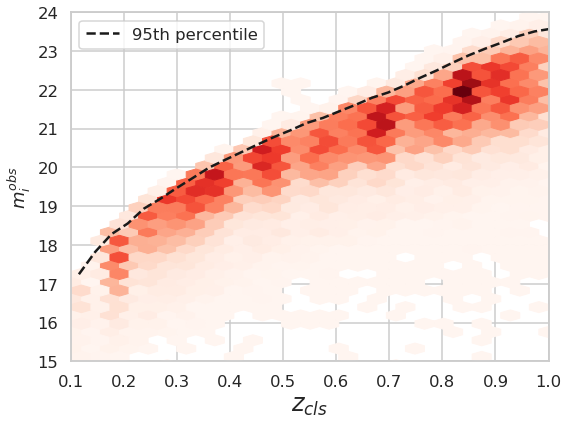

In [22]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,magi,weights=pmem)
plt.xlim(0.1,1.0)
plt.ylim(15,24)
plt.ylabel('$m_{i}^{obs}$')
plt.tight_layout()
plt.savefig('mag_obs_cut.png')

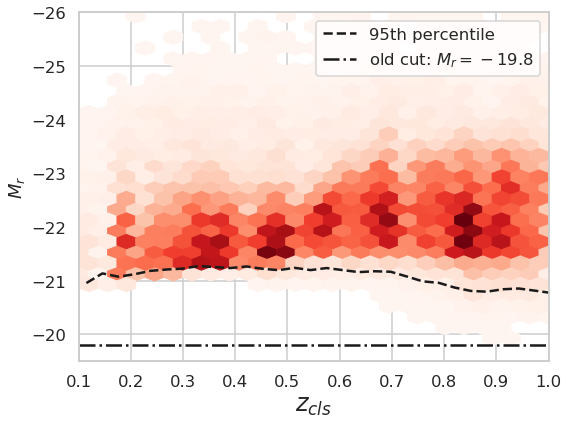

In [23]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,amag,weights=pmem)
plt.axhline(-19.8,color='k',linestyle='-.',label='old cut: $M_{r}=-19.8$')
plt.xlim(0.1,1.0)
plt.ylim(-19.5,-26)
plt.legend()
plt.ylabel('$M_{r}$')
plt.tight_layout()
plt.savefig('amag_cut.png')

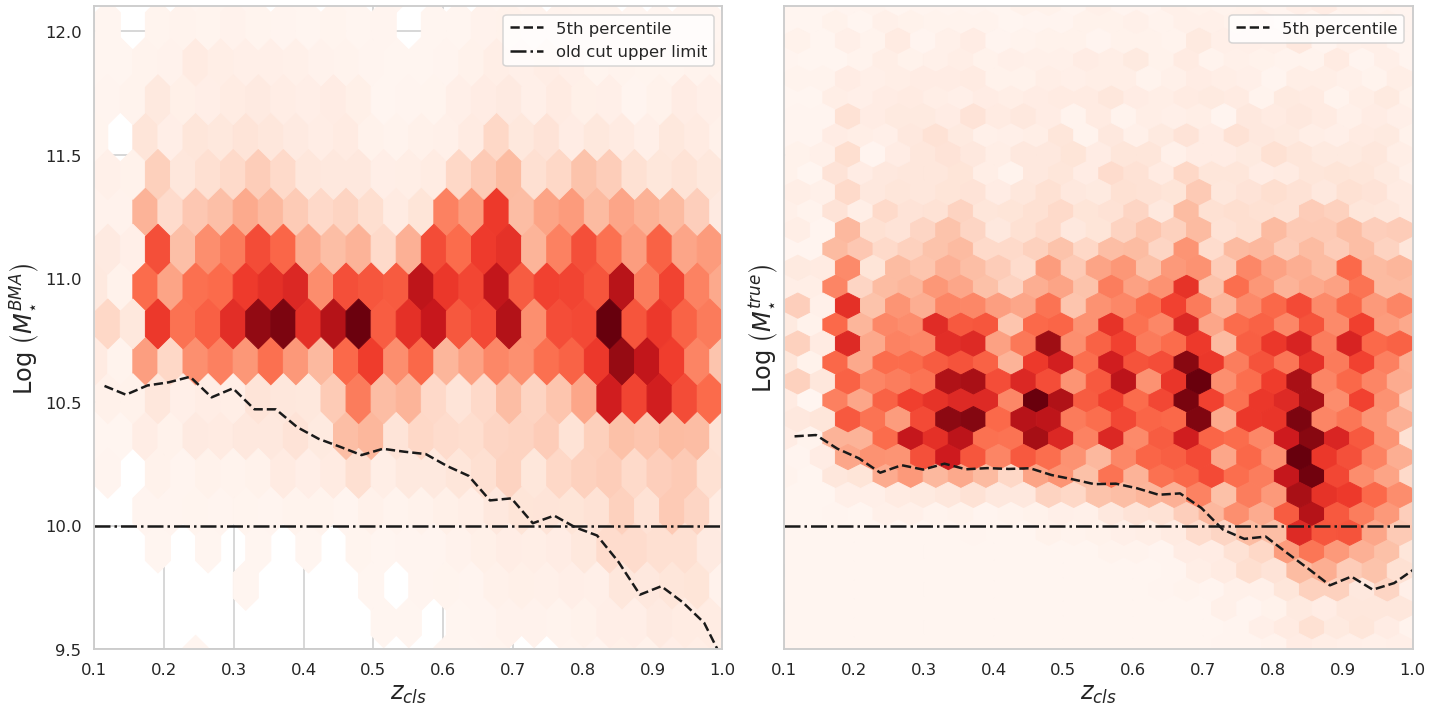

In [24]:
fig, ax = plt.subplots(1,2, sharey='row', sharex='row', figsize=(20,10))
fig.subplots_adjust(wspace=0.15)

plot_redshift_variable(zcls[bads],np.log10(mass[bads]),weights=pmem[bads],q=5,ax=ax[0])
plot_redshift_variable(zcls[mask],np.log10(mass_t[mask]),q=5, ax=ax[1])

ax[0].set_ylabel(r'Log $\left( M_{\star}^{BMA} \right)$',fontsize=24)
ax[1].set_ylabel(r'Log $\left( M_{\star}^{true} \right)$',fontsize=24)

ax[0].set_ylim(9.5,12.1)
ax[0].set_xlim(0.1,1.)

for i in range(2):
    ax[i].axhline(10,color='k',linestyle='-.',label='old cut upper limit')

ax[0].legend()
plt.tight_layout()

plt.savefig('stellar_mass_cut.png')